# Rendimiento de la evaluación de Dirección de Tesis I

Para este análisis, usaremos Python 3.7.7 en JupyterLab 2.1.5 de la Distribución Anaconda 2020-07 (Anaconda Inc., Austin, TX). En primer lugar, importaremos las librerías que necesitaremos para el análisis de datos y la visualización de resultados

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats

A continuación, importaremos la base de datos con toda la información acerca de la evaluación. Seleccionaremos 2 columnas para el análisis, la fecha de la evaluación y el puntaje obtenido. Haremos también algunos ajustes con respecto a estas variables, para que puedan ser analizadas apropiadamente. Agregaremos también una columna conteniendo un identificador para cada fila. Finalmente, echaremos un vistazo a las primeras 5 filas de la tabla de datos.

In [2]:
dataset = pd.read_csv('DT1.csv', usecols=[7,10], na_values='-')
dataset = dataset.iloc[:-1,:]
dataset.rename(columns={'Comenzado el':'Fecha','Calificación/50':'Puntaje'}, inplace=True)
dataset = dataset.astype({'Fecha':'category'})
dataset['Fecha'] = dataset['Fecha'].apply(lambda x: '24/07' if '24 de julio' in x else '31/07')
dataset['N'] = range(len(dataset))
dataset.head()

,Fecha,Puntaje,N
0,24/07,NaN,0
1,24/07,38.0,1
2,24/07,33.0,2
3,24/07,27.0,3
4,24/07,25.0,4


In [3]:
dataset.shape

(34, 3)

Como podemos ver, en la columna de `Fecha` tenemos la fecha de las 2 evaluaciones que se realizaron, el 24 y el 31 de julio. En la columna de `Puntaje` tenemos los puntajes obtenidos. La columna `N` es un índice identificador que usaremos más tarde para presentar los resultados. Tenemos 34 filas, indicando 2 evaluaciones, 17 por cada fecha.

## Comparación de puntajes

Lo primero que haremos será comparar los puntajes obtenidos por cada evaluación. Para esto, empezaremos por mostrar los datos usando diagramas de cajas. Si quieren más información sobre los diagramas de cajas pueden consultar [aquí](https://es.wikipedia.org/wiki/Diagrama_de_caja).

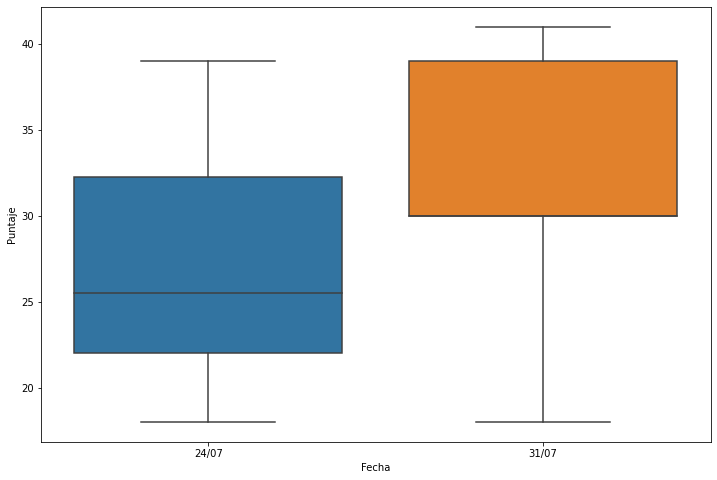

In [4]:
plt.figure(figsize=(12,8))
sns.boxplot(data=dataset, x='Fecha', y='Puntaje')
plt.show()

Ya a primera vista, podemos notar que los puntajes obtenidos el 31/07 fueron mayores que los obtenidos el 24/07. Lo siguiente que haremos será mostrar la tabla de valores de tendencia central y dispersión de los puntajes obtenidos, por cada fecha. Si quieren revisar más acerca de los valores de tendencia central, pueden hacerlo [aquí](https://es.wikipedia.org/wiki/Medidas_de_tendencia_central). Si quieren saber más acerca de los valores de dispersión, pueden hacerl [aquí](https://es.wikipedia.org/wiki/Medidas_de_dispersión).

In [5]:
dataset.groupby('Fecha')['Puntaje'].describe()

,count,mean,std,min,25%,50%,75%,max
Fecha,,,,,,,,
24/07,16.0,27.250000,6.836178,18.0,22.0,25.5,32.25,39.0
31/07,17.0,32.470588,6.236161,18.0,30.0,30.0,39.00,41.0


Como podemos ver, los valores promedios de los puntajes subieron de 27 puntos a 32 puntos entre la primera y la segunda fecha. Los valores medianos subieron por un valor similar (de 25 puntos a 30 puntos). Los valores de dispersión (desviación estándar, rango interquartilo) fueron similares entre ambas fechas, lo que indica varianzas homogéneas (esto será importante después para elegir la prueba estadística apropiada). Lo mismo con los valores promedios y medianos, lo que indica que es razonable asumir una distribución normal para los puntajes por fechas.

Lo siguiente será comparar si las distribuciones de los puntajes por fechas son diferentes entre sí. Para esto (y tomando todo lo anterior con respecto a las presunciones de normalidad y varianzas homogéneas), usaremos la prueba t de Student para muestras no pareadas (independientes). Si quieren saber más acerca de la prueba t de Student, pueden hacer [aquí](https://es.wikipedia.org/wiki/Prueba_t_de_Student).

In [6]:
scipy.stats.ttest_ind(*[df['Puntaje'].values for name, df in dataset.groupby('Fecha')], nan_policy='omit')

Ttest_indResult(statistic=-2.294083552763562, pvalue=0.02872129957983258)

La prueba t de Student muestra un estadístico $t = 2.29$ y un valor $P = 0.03$, indicando que las diferencias son estadísticamente significativas al nivel estándar de $P<0.05$. Si quieren saber más acerca del valor P pueden hacerlo [aquí](https://es.wikipedia.org/wiki/Valor_p).

## Comparación de calificaciones

Ya vimos que los puntajes son significativamente diferentes entre una fecha y otra. Sin embargo, para aprobar la evalución, se requiere alcanzar el 70% del puntaje (es decir, 35 puntos). Lo siguiente que haremos será clasificar los puntajes obtenidos de acuerdo a este punto de corte.

In [7]:
dataset['Calificación'] = dataset['Puntaje'].apply(lambda x: 'Aprobado' if x >= 35 else 'Reprobado')
dataset.head()

,Fecha,Puntaje,N,Calificación
0,24/07,NaN,0,Reprobado
1,24/07,38.0,1,Aprobado
2,24/07,33.0,2,Reprobado
3,24/07,27.0,3,Reprobado
4,24/07,25.0,4,Reprobado


Como podemos ver, hemos agregado una nueva columna `Calificación` a la tabla de datos. Veamos la distribución de estos valores usando un gráfico de barras. Si quieren saber más acerca de los gráficos de barras, pueden hacerlo [aquí](https://es.wikipedia.org/wiki/Diagrama_de_barras).

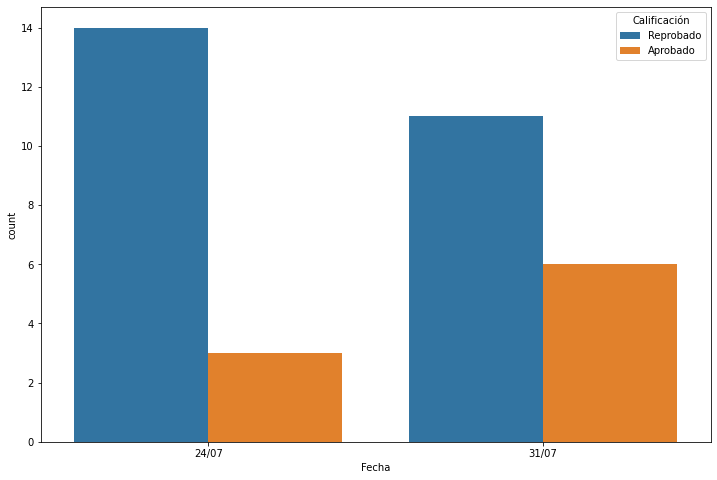

In [8]:
plt.figure(figsize=(12,8))
sns.countplot(data=dataset, x='Fecha', hue='Calificación')
plt.show()

A simple vista, podemos notar que, aunque la proporción de aprobados aumentó, aún sigue siendo mayor la proporción de reprobados. Vamos la tabla de distribución de frecuencia de estos valores.

In [9]:
tbl = dataset.groupby(['Fecha','Calificación'])['N'].count().to_frame()
tbl

N
Fecha Calificación    
24/07 Aprobado       3
      Reprobado     14
31/07 Aprobado       6
      Reprobado     11

Esta tabla no es tan fácil de interpretar, así que la transformaremos en una tabla pivote, también llamada tabla dinámica. Si quieren saber más acerca de tablas dinámicas, pueden hacerlo [aquí](https://es.wikipedia.org/wiki/Tabla_dinámica).

In [10]:
tbl_pivot = pd.pivot_table(tbl, index='Calificación', columns='Fecha', values='N')
tbl_pivot

Fecha,24/07,31/07
Calificación,,
Aprobado,3,6
Reprobado,14,11


Ahora podemos notar mejor los valores. El número de aprobados pasó de 3 alumnos a 6 alumnos. Esto implica que el número de aprobados se duplicó. Lo siguiente que tenemos que evaluar entonces es si estas diferencias, este incremento es estadístísicamente significativo. Para esto, usaremos la prueba del $\chi^2$ de Pearson e interpretaremos los resultados mediante el valor P. Si quieren saber más acerca de la prueba del $\chi^2$ de Pearson pueden hacerlo [aquí](https://es.wikipedia.org/wiki/Prueba_χ²_de_Pearson).

In [11]:
scipy.stats.chi2_contingency(tbl_pivot)

(0.6044444444444443,
 0.43688727610282685,
 1,
 array([[ 4.5,  4.5],
        [12.5, 12.5]]))

El valor del estadístico es $\chi^2=0.60$ y el valor $P=0.44$. Esto indica que las diferencias en proporción observadas no son estadísticamente significativas.

## Conclusiones

Tras este análisis, podemos concluir que los puntajes entre el 24/07 y el 31/07 son diferentes, notándose un incremento estadísticamente significativo de 5 puntos en promedio. Sin embargo, las proporciones entre aprobados y reprobados no son diferentes a un nivel estadísticamente significativo. Por lo tanto, por más que el rendimiento en términos de puntajes ha mejorado, el rendimiento con respecto a la calificación aprobado/reprobado sigue siendo el mismo.